In [1]:
!python --version

Python 3.7.6


In [2]:
import os,sys,re
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print ("CV2 Version - "+str(cv2.__version__))
print ("numpy Version - "+str(np.__version__))

CV2 Version - 4.1.0
numpy Version - 1.18.1


In [3]:
input_images = os.listdir("images/")

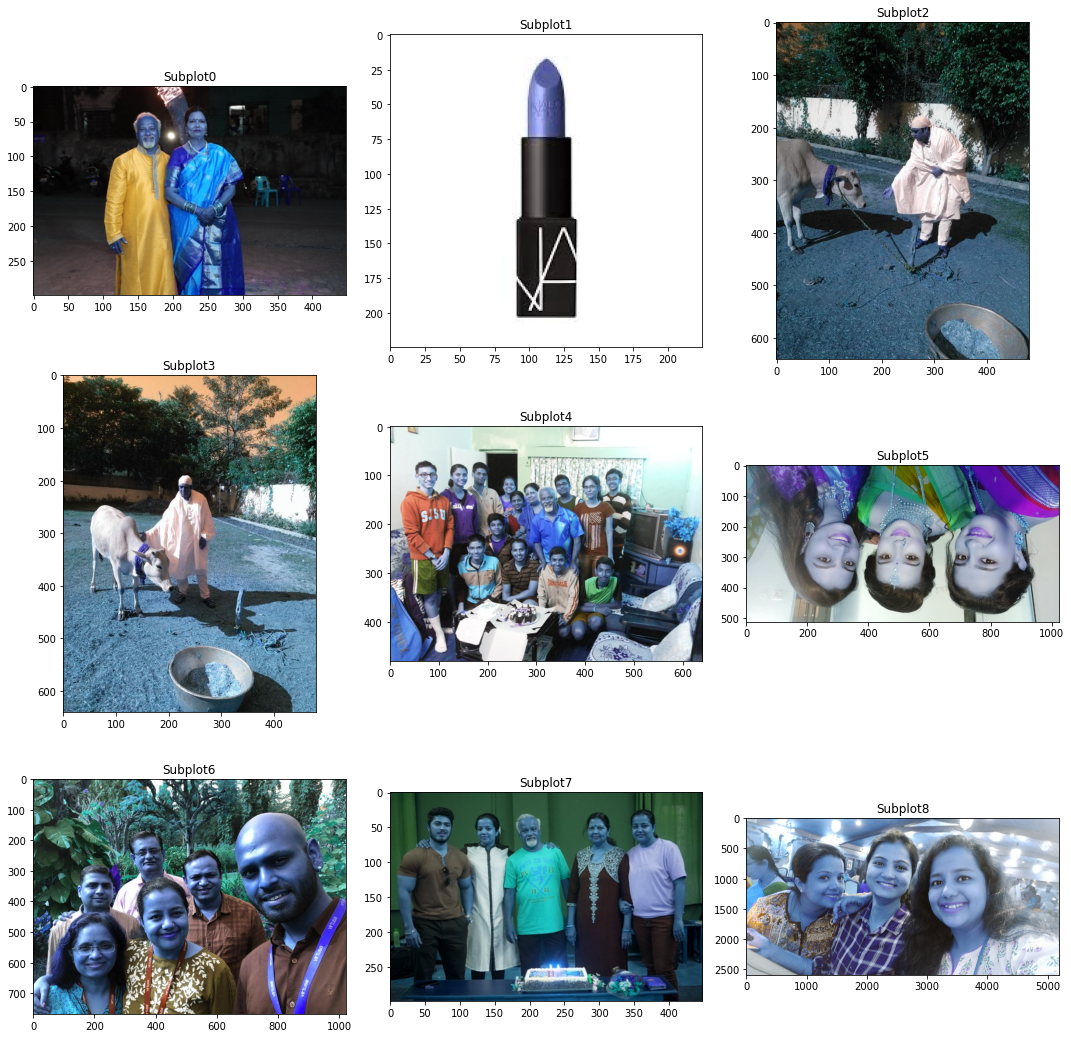

In [4]:
width=15
height=15
rows = 3
cols = 3
axes=[]
fig=plt.figure(figsize=(15,15))

for a in range(len(input_images)):
    input_img = "images/"+input_images[a]
    img = cv2.imread(input_img, cv2.COLOR_BGR2RGB)
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(img)

fig.tight_layout()    
plt.show()

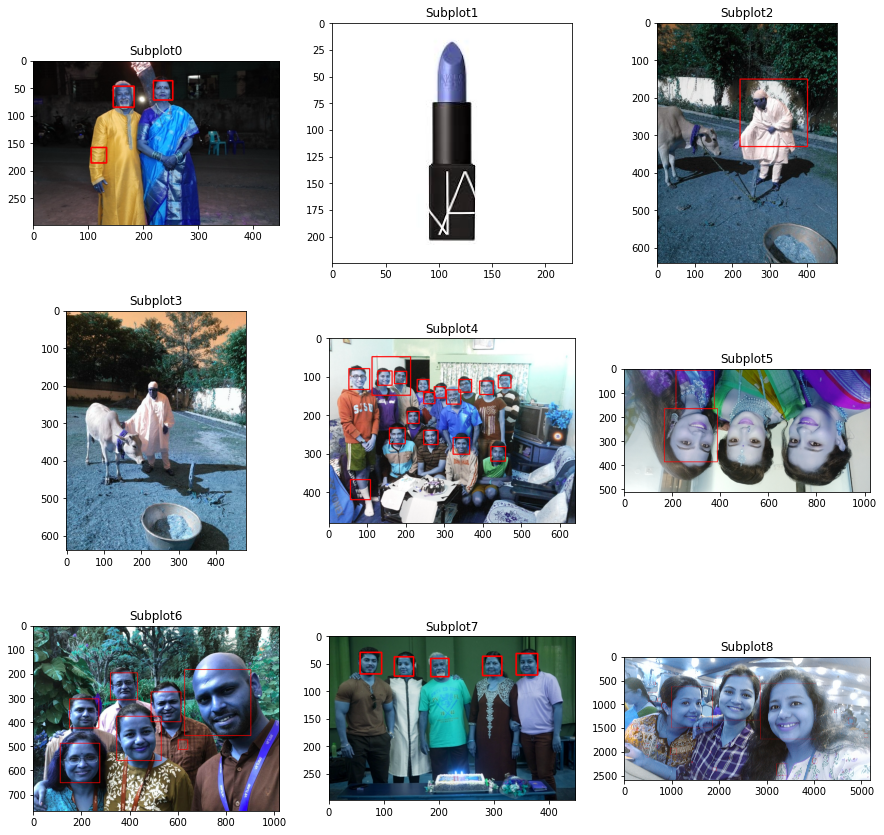

In [5]:
width=15
height=15
rows = 3
cols = 3
axes=[]
fig=plt.figure(figsize=(15,15))
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for a in range(len(input_images)):
    input = "images/"+input_images[a]
    img = cv2.imread(input, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, minSize =(20, 20))
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(img)
plt.show()

In [6]:
#!wget https://pjreddie.com/media/files/yolov3.weights
#!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
#!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names

In [7]:
# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5

# Setting threshold for non maximum suppression
threshold = 0.3

In [8]:
configuration_path = "yolov3.cfg"
weights_path = "yolov3.weights"
network = cv2.dnn.readNetFromDarknet("yolov3.cfg", "yolov3.weights")
# Getting names of all layers
layers_names_all = network.getLayerNames()

In [9]:
# Getting only output layers' names that we need from YOLO algorithm
layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]  # list of layers' names

# Check point
print(layers_names_output)

['yolo_82', 'yolo_94', 'yolo_106']


In [10]:
# Our image initially is in RGB format
# But now we open it in BGR format as function 'cv2.imread' opens it so
image_input = cv2.imread('images/3.jpg')

# Getting image shape
image_input_shape = image_input.shape

# Check point
print(image_input_shape)

(640, 480, 3)


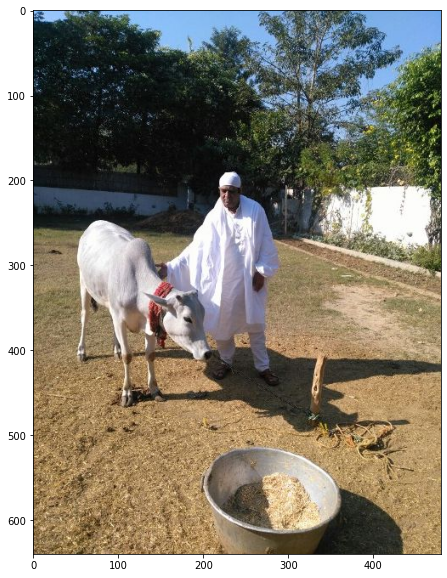

In [11]:
# Showing RGB image but firstly converting it from BGR format
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Check point
print(image_input.shape)  # (917, 1222, 3)
print(blob.shape)  # (1, 3, 416, 416)

(640, 480, 3)
(1, 3, 416, 416)


(416, 416, 3)


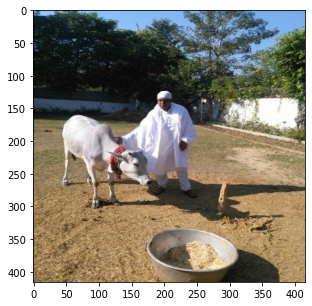

In [13]:
# Check point
# Slicing blob and transposing to make channels come at the end
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  # (416, 416, 3)

# Showing 'blob_to_show'
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

In [14]:
import time
# Calculating at the same time, needed time for forward pass
network.setInput(blob)  # setting blob as input to the network
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Showing spent time for forward pass
print('YOLO v3 took {:.5f} seconds'.format(end - start))

YOLO v3 took 4.28825 seconds


In [15]:
labels = open('coco.names').read().strip().split('\n')  # list of names
print(labels)
# Seed the generator - every time we run the code it will generate by the same rules
# In this way we can keep specific colour the same for every class
np.random.seed(42)
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(colours.shape)  # (80, 3)
print(colours[0])  # [102 220 225]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
(80, 3)
[102 220 225]


In [16]:
bounding_boxes = []
confidences = []
class_numbers = []

# Getting spacial dimension of input image
h, w = image_input_shape[:2]  # Slicing from tuple only first two elements

# Check point
print(h, w)  # 917 1222

640 480


In [17]:
for result in output_from_network:
    # Going through all detections from current output layer
    for detection in result:
        # Getting class for current object
        scores = detection[5:]
        class_current = np.argmax(scores)

        # Getting confidence (probability) for current object
        confidence_current = scores[class_current]
        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps center of detected box and its width and height
            # That is why we can just elementwise multiply them to the width and height of the image
            box_current = detection[0:4] * np.array([w, h, w, h])

            # From current box with YOLO format getting top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [18]:
# It is needed to make sure the data type of the boxes is 'int'
# and the type of the confidences is 'float'
# https://github.com/opencv/opencv/issues/12789
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Check point
# Showing labels of the detected objects
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

# Saving found labels
with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])

person
cow
bowl


In [19]:
# Checking if there is at least one detected object
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Getting current bounding box coordinates
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        # Drawing bounding box on the original image
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])

        # Putting text with label and confidence on the original image
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)

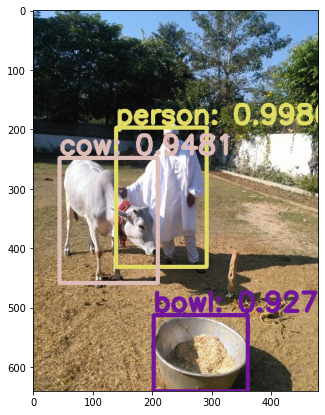

In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 7)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
" , ".join(labels)

'person , bicycle , car , motorbike , aeroplane , bus , train , truck , boat , traffic light , fire hydrant , stop sign , parking meter , bench , bird , cat , dog , horse , sheep , cow , elephant , bear , zebra , giraffe , backpack , umbrella , handbag , tie , suitcase , frisbee , skis , snowboard , sports ball , kite , baseball bat , baseball glove , skateboard , surfboard , tennis racket , bottle , wine glass , cup , fork , knife , spoon , bowl , banana , apple , sandwich , orange , broccoli , carrot , hot dog , pizza , donut , cake , chair , sofa , pottedplant , bed , diningtable , toilet , tvmonitor , laptop , mouse , remote , keyboard , cell phone , microwave , oven , toaster , sink , refrigerator , book , clock , vase , scissors , teddy bear , hair drier , toothbrush'